###### Can I predict the existence of subfields with some cool unsupervised learning algorithm? 

For starters, let's just use regular n-grams. A more advanced version would be to look for noun phrases or J&K POS tags.

In [1]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../')

%matplotlib inline
# import matplotlib.pyplot as plt
import time
import numpy as np
# import scipy as sp
import re
from collections import Counter
import itertools
import random

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
# from nltk.corpus import stopwords
# s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import SparsePCA
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
# from sklearn import metrics
from sklearn.externals import joblib

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

import json

from matplotlib import pyplot as plt

engine = create_engine("sqlite:///../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [2]:
# What are the available categories?
categories = sorted([x.name for x in session.query(Category)])
print categories 

[u'acc-phys', u'adap-org', u'alg-geom', u'ao-sci', u'astro-ph', u'astro-ph.CO', u'astro-ph.EP', u'astro-ph.GA', u'astro-ph.HE', u'astro-ph.IM', u'astro-ph.SR', u'atom-ph', u'bayes-an', u'chao-dyn', u'chem-ph', u'comp-gas', u'cond-mat', u'cond-mat.dis-nn', u'cond-mat.mes-hall', u'cond-mat.mtrl-sci', u'cond-mat.other', u'cond-mat.quant-gas', u'cond-mat.soft', u'cond-mat.stat-mech', u'cond-mat.str-el', u'cond-mat.supr-con', u'cs.AI', u'cs.AR', u'cs.CC', u'cs.CE', u'cs.CG', u'cs.CL', u'cs.CR', u'cs.CV', u'cs.CY', u'cs.DB', u'cs.DC', u'cs.DL', u'cs.DM', u'cs.DS', u'cs.ET', u'cs.FL', u'cs.GL', u'cs.GR', u'cs.GT', u'cs.HC', u'cs.IR', u'cs.IT', u'cs.LG', u'cs.LO', u'cs.MA', u'cs.MM', u'cs.MS', u'cs.NA', u'cs.NE', u'cs.NI', u'cs.OH', u'cs.PF', u'cs.PL', u'cs.RO', u'cs.SC', u'cs.SD', u'cs.SE', u'cs.SI', u'cs.SY', u'dg-ga', u'funct-an', u'gr-qc', u'hep-ex', u'hep-lat', u'hep-ph', u'hep-th', u'math-ph', u'math.AC', u'math.AG', u'math.AP', u'math.AT', u'math.CA', u'math.CO', u'math.CT', u'math.CV',

In [3]:
abstract_all_tmp = {'category': [], 'abstract': []}
# category_list = sorted(['atom-ph', 'quant-ph', 'optics', 'nlin', 'str-el', 'stat'])
category_list = sorted(['atom-ph', 'quant-gas'])
category_len = len(category_list)

start = time.time()
for item in category_list:
    query = session.query(Article_Category)\
                        .join(Category)\
                        .join(Article)\
                        .filter(Category.name.like('%' + item + '%'))
#     query = session.query(Article_Category)\
#                         .join(Category)\
#                         .join(Article)\
#                         .filter(Category.name.like('%' + item + '%'))
    result = [' '.join(x.article.abstract.split()) for x in query]
    abstract_all_tmp['abstract'].extend(result)
    abstract_all_tmp['category'].extend([item]*len(result))
print time.time() - start
# for item in query:
#     abstract_all['category'].append(item.category.name)
#     abstract_all['abstract'].append(' '.join(item.article.abstract.split()))
# print time.time() - start
# abstract_all['atom-ph'] = [x.article.abstract for x in query.all()]
# session.close_all()

26.9663009644


In [4]:
# Breakdown of categories?
count = Counter(abstract_all_tmp['category'])
for key, val in count.iteritems():
    print '{:<15}{}'.format(key, val)
print '{:<15}{}'.format('Total', len(abstract_all_tmp['abstract']))

quant-gas      9107
atom-ph        9156
Total          18263


In [5]:
abstract_all = abstract_all_tmp

In [6]:
# Train on 80% of the data. Random_state ensures that we always get the same result.
x_train, x_test, y_train, y_test = train_test_split(abstract_all['abstract'],
                                                    abstract_all['category'],
                                                    random_state=42,
                                                    train_size=0.8)

counter_train = Counter(y_train)

Now, try KMeans clustering. 
See: http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

In [7]:
#Load articles from DAMOP
with open('../../damop data/damop2016.json') as f:
    damop = json.load(f)

In [8]:
def kmeans(n_clusters, n_init=5):
    # 20 is good
    # n_clusters = 20
    # n_clusters = 20
    # Reduce n_init to 10 for testing purposes.
    clf_unsupervised = Pipeline([('vect', CountVectorizer(ngram_range=(1,3), stop_words='english')),
                                 ('tfidf', TfidfTransformer()),
                                 ('clf', KMeans(n_clusters=n_clusters, n_init=n_init, n_jobs=-1))])
    start = time.time()
    clf_unsupervised.fit(x_train)
    print time.time() - start

#     start = time.time()
    predict_train = clf_unsupervised.predict(x_train)
    predict = clf_unsupervised.predict(x_test)
#     print time.time() - start
    return clf_unsupervised

In [9]:
def fit_damop(clf):
    sessions_all = 0
    sessions_one_majority = 0
    sessions_two_majority = 0

    n_clusters = clf.get_params()['clf__n_clusters']
    cluster_to_session = dict((x, []) for x in range(n_clusters))
    sessions_unclassified = []

    for session in damop:
        abstracts = map(lambda x: x['abstract'], session['abstracts'])
        if (len(abstracts) > 5) and (len(abstracts) < 40):
            y = clf.predict(abstracts)
            count = Counter(y)
            session_number_name = "{}: {}".format(session['number'], session['name'])
#             print session_number_name
            sessions_all += 1

            if 1.*count.most_common(1)[0][1] >= 0.5*len(abstracts):
#                 print 'Majority cluster: {}'.format(count.most_common(1)[0][0])
                sessions_one_majority += 1

                cluster_to_session[count.most_common(1)[0][0]].append(session_number_name + ' (*)')

            elif 1.*(count.most_common(2)[0][1] + count.most_common(2)[1][1]) >= 0.5*len(abstracts):
#                 print 'Majority clusters: {}, {}'.format(count.most_common(2)[0][0], count.most_common(2)[1][0])
                sessions_two_majority += 1

                cluster_to_session[count.most_common(2)[0][0]].append(session_number_name)
                cluster_to_session[count.most_common(2)[1][0]].append(session_number_name)

            else:
#                 print y
                sessions_unclassified.append(session_number_name)
#             print ''
    return (sessions_one_majority*1./sessions_all, (sessions_one_majority+sessions_two_majority)*1./sessions_all)
    #         if session['number'] == 'N6':
    #             break

Show the probability of a session falling largely into one or two categories.

In [10]:
sessions_one_majority = []
sessions_two_majority = []
n_clusters = range(1, 61, 1)*3
# n_clusters = range(1, 61, 20)*1
for n in n_clusters:
    print n
#     print (n, 8 * 2**(n/10.))
    clf = kmeans(n, n_init=1)
    tmp = fit_damop(clf)
    sessions_one_majority.append(tmp[0])
    sessions_two_majority.append(tmp[1])

1
17.8316409588
2
18.1892399788
3
26.7886769772
4
24.542265892
5
31.221642971
6
34.7564809322
7
39.7621240616
8
40.7287638187
9
54.8679161072
10
40.3136270046
11
30.9284760952
12
51.8687129021
13
47.3253180981
14
39.3850119114
15
55.226859808
16
73.486746788
17
47.4799599648
18
50.6787850857
19
65.1079859734
20
47.3298220634
21
55.1821060181
22
71.2809200287
23
83.0366108418
24
59.4687108994
25
66.7811911106
26
88.2338042259
27
59.2586009502
28
93.0401029587
29
92.4071130753
30
77.0480370522
31
103.411603928
32
127.884741068
33
104.984586
34
67.458509922
35
68.9825298786
36
68.9145870209
37
112.078252077
38
123.72567606
39
67.3714849949
40
97.895170927
41
102.375869989
42
104.655831099
43
96.468405962
44
98.6550018787
45
75.944642067
46
142.490445137
47
171.987983942
48
117.615961075
49
167.571096897
50
95.9045960903
51
137.177714109
52
112.616941929
53
275.973286152
54
330.687478065
55
195.435050011
56
242.079823971
57
263.994275093
58
204.433226109
59
315.418782949
60
471.925930977
1

In [11]:
with open("cluster-number-AMO.json", "w") as f:
    json.dump({'n_clusters': n_clusters,
               'sessions_one_majority': sessions_one_majority,
               'sessions_two_majority': sessions_two_majority},
              f)
# with open("cluster-number-AMO.json", "r") as f:
#     tmp = json.load(f)
#     n_clusters = tmp['n_clusters']
#     sessions_one_majority = tmp['sessions_one_majority']
#     sessions_two_majority = tmp['sessions_two_majority']

In [12]:
with open("cluster-random.json") as f:
    data_random = json.load(f)

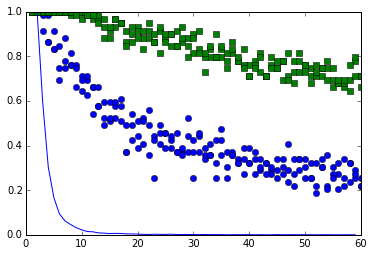

In [13]:
plt.plot(n_clusters, sessions_one_majority, 'bo',
         n_clusters, sessions_two_majority, 'gs',
         data_random['k'], data_random['prob'], 'b-')

In [14]:
print fit_damop(joblib.load('cluster-AMO.pkl') )

(0.5423728813559322, 0.9491525423728814)


Fix the cluster size at 20. How many n_init do we need before the quality saturates?

In [15]:
# # 100 iterations takes roughly 45 min, though I'm not completely sure.
# sessions_one_majority_20_init = []
# sessions_two_majority_20_init = []
# n_init = range(0, 101, 10)
# # n_init = range(0, 41, 20)
# n_init[0] = 1
# for n in n_init:
#     print n
#     clf = kmeans(20, n_init=n)
#     tmp = fit_damop(clf)
#     sessions_one_majority_20_init.append(tmp[0])
#     sessions_two_majority_20_init.appendd(tmp[1])

In [16]:
# with open("cluster-number-n_init.json", "w") as f:
#     json.dump({'n_init': n_init,
#                'sessions_one_majority_20': sessions_one_majority_20_init,
#                'sessions_two_majority_20': sessions_two_majority_20_init,
#               },
#               f)
# # with open("cluster-number-n_init.json", "w") as f:
# #     json.dump({'n_init': n_init,
# #                'sessions_one_majority_20': sessions_one_majority_20_init,
# #                'sessions_two_majority_20': sessions_two_majority_20_init,
# #                'sessions_one_majority_40': sessions_one_majority_40_init,
# #                'sessions_two_majority_40': sessions_two_majority_40_init,},
# #               f)

#### The hypothesis I'm testing above is that a "better" cluster (one that minimizes kmeans) will provide capture more groups of DAMOP sessions.
This can be tested by comparing each single optimization of the kmeans algorithm with how well it classifies DAMOP sessions. This should be computationally more efficient than varying n_init.

In [17]:
def kmeans2(n_clusters, n_init=5):
    # 20 is good
    # n_clusters = 20
    # n_clusters = 20
    # Reduce n_init to 10 for testing purposes.
    clf_unsupervised = Pipeline([('vect', CountVectorizer(ngram_range=(1,3), stop_words='english')),
                                 ('tfidf', TfidfTransformer()),
                                 ('clf', KMeans(n_clusters=n_clusters, n_init=n_init, n_jobs=-1))])
    start = time.time()
    clf_unsupervised.fit(x_train)
    print time.time() - start

#     start = time.time()
    predict_train = clf_unsupervised.predict(x_train)
    predict = clf_unsupervised.predict(x_test)
#     print time.time() - start
    return clf_unsupervised

In [18]:
# 100 iterations takes roughly 45 min, though I'm not completely sure.
sessions_one_majority_init = []
sessions_two_majority_init = []
inertia = []
# for x in range(10):
for x in range(100):
    clf = kmeans(20, n_init=1)
    tmp = fit_damop(clf)
    sessions_one_majority_init.append(tmp[0])
    sessions_two_majority_init.append(tmp[1])
    inertia.append(clf.named_steps['clf'].inertia_)
    print (sessions_one_majority_init[-1], inertia[-1])

60.6122989655
(0.5254237288135594, 14425.710124145911)
62.3655381203
(0.5423728813559322, 14420.150946256099)
73.7811150551
(0.559322033898305, 14425.140960055109)
69.9626729488
(0.3389830508474576, 14426.510661400654)
160.28984189
(0.4745762711864407, 14420.038042996805)
78.7621400356
(0.5084745762711864, 14420.68926308823)
89.4217598438
(0.3898305084745763, 14430.21542012058)
76.3648991585
(0.4406779661016949, 14426.36248341202)
74.5159919262
(0.4406779661016949, 14428.192968699288)
86.3000359535
(0.4576271186440678, 14422.992636493425)
110.073373079
(0.559322033898305, 14422.608126485748)
81.5292458534
(0.5254237288135594, 14423.014215422587)
87.4239392281
(0.4915254237288136, 14419.866797880235)
126.341399908
(0.4745762711864407, 14425.032617858318)
79.866396904
(0.4406779661016949, 14427.18291326705)
75.5493228436
(0.4745762711864407, 14424.233000765984)
58.1186289787
(0.559322033898305, 14424.336860310437)
134.19047904
(0.4576271186440678, 14426.851326689644)
56.4827399254
(0.491

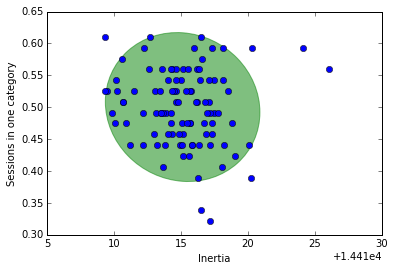

In [21]:
import error_ellipse
plt.plot(inertia, sessions_one_majority_init, 'o')
error_ellipse.plot_point_cov(np.array([inertia, sessions_one_majority_init]).T,
                             nstd=2,
                             alpha=0.5,
                             color='green')
plt.xlabel('Inertia')
plt.ylabel('Sessions in one category')
# plt.xlim([0, max(inertia)*2])
# plt.ylim([0, 1])
# plt.xlim()

In [20]:
with open("cluster-number-AMO-inertia.json", "w") as f:
    json.dump({'inertia': inertia,
               'sessions_one_majority_init': sessions_one_majority_init,
               'sessions_two_majority_init': sessions_two_majority_init,
              },
              f)
# with open("cluster-number-n_init.json", "w") as f:
#     json.dump({'n_init': n_init,
#                'sessions_one_majority_20': sessions_one_majority_20_init,
#                'sessions_two_majority_20': sessions_two_majority_20_init,
#                'sessions_one_majority_40': sessions_one_majority_40_init,
#                'sessions_two_majority_40': sessions_two_majority_40_init,},
#               f)